<div style="border: 2px solid #007bff; padding: 10px; border-radius: 5px;">

# Project Overview

Beta Bank is losing customers. The goal of this project is to predict whether a customer will leave the bank soon.


## Methodology

1. The goal is to achieve an F1 score of at least 0.59.
2. Prepare the data for analysis.
3. Train the model as-is, and determine the model type (and parameters) that will achieve the highest F1 score.
4. Address imbalance, and improve the quality of the model.

</div>

<div style="border: 2px solid #007bff; padding: 10px; border-radius: 5px;">

# Environment Setup and Required Libraries
</div>


In [1]:
import pandas as pd
import warnings
import dsr_data_tools as ddt
import dsr_feature_eng_ml as dfem
from scipy.stats import randint as sp_randint
from sklearn.metrics import f1_score

# Suppress the l1_ratio deprecation warning from scikit-learn
warnings.filterwarnings('ignore', message="'l1_ratio=None' was deprecated")

## 1&emsp;Data Preparation

### 1.1&emsp;Load and Analyze the Dataset

In [2]:
cust_churn = pd.read_csv('./datasets/Churn.csv')
dataset_target_column = 'Exited'

df_info, recommendations = ddt.analyze_dataset(
    df=cust_churn, 
    target_column=dataset_target_column, 
    generate_recs=True
)

Rows: 10000
Duplicate rows: 0

Column           Non-null   Data type   
RowNumber           10000   int64       
CustomerId          10000   int64       
Surname             10000   object      
CreditScore         10000   int64       
Geography           10000   object      
Gender              10000   object      
Age                 10000   int64       
Tenure               9091   float64     
Balance             10000   float64     
NumOfProducts       10000   int64       
HasCrCard           10000   int64       
IsActiveMember      10000   int64       
EstimatedSalary     10000   float64     
Exited              10000   int64       

Column:             RowNumber
Data type:          int64
Non-null:           10000
N/A count:          0
Unique values:      10000
Min value:          1
Max value:          10000

  Recommendations:
  Recommendation: NON_INFORMATIVE
    Reason: Unique count equals row count
    Action: Drop column 'RowNumber'


Column:             CustomerId
Data type:

### 1.2&emsp;Apply Data Preparation Recommendations

In [3]:
# Omit BINNING recommendations for base feature set
cust_churn_base = ddt.apply_recommendations(
    df=cust_churn,
    recommendations=recommendations,
    exclude_types=[ddt.RecommendationType.BINNING],
    target_column=dataset_target_column
)

cust_churn_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9091 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Gender             9091 non-null   Int64  
 2   Age                9091 non-null   float64
 3   Tenure             9091 non-null   float64
 4   Balance            9091 non-null   float64
 5   NumOfProducts      9091 non-null   float64
 6   HasCrCard          9091 non-null   bool   
 7   IsActiveMember     9091 non-null   bool   
 8   EstimatedSalary    9091 non-null   float64
 9   Exited             9091 non-null   int64  
 10  Geography_France   9091 non-null   bool   
 11  Geography_Germany  9091 non-null   bool   
 12  Geography_Spain    9091 non-null   bool   
dtypes: Int64(1), bool(5), float64(5), int64(2)
memory usage: 692.5 KB


## 2&emsp;Model Training

### 2.1&emsp;Configuration Parameters

In [4]:
# Parameters for Decision Tree models
dtree_param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100]
}

# Values that can be used with GridSearchCV
rf_param_grid = {
    'n_estimators': [10, 20, 30, 40, 50], # Test a discrete range
    'max_depth': [5, 10, 20, 50], # Test more max_depths
}

# Parameters for Logistic Regression models
# Note: LBFGS solver only supports L2 (ridge) penalty or no penalty
# Removed l1_ratio since lbfgs does not support L1 or ElasticNet penalties
lr_param_grid = {
    'C': sp_randint(10, 51),
    'solver': ['lbfgs']
}

# Configuration Parameters
ml_config_data_split_test_size = 0.2
ml_config_data_split_valid_size = 0.25
ml_config_random_state = 75
ml_config_cv = 5
ml_config_n_iter = 50
ml_config_max_iter = 1000
ml_config_scoring = 'f1'
ml_config_n_jobs = -1
ml_config_viable_f1_gap = 0.01

# Best model results
best_model_results = dfem.BestModelResults()

# Reset phase number
dfem.ModelEvaluation.phase_number = 0

## 3&emsp;Model Evaluation.

The goal is to achieve an F1 score of at least 0.59 on the test dataset. The following evaluations compare different model types and imbalance-handling strategies.

### 3.1&emsp;Phase 1 - Base Feature Set.  

Using the features of the dataset as-is (following data preparation) provides a baseline for model evaluation.

In [5]:
# Increment phase counter
dfem.ModelEvaluation.phase_number += 1

# Prepare features and create data splits
all_features = cust_churn_base.columns.to_list()
all_features.remove(dataset_target_column)

data_splits = dfem.DataSplits.from_data_source(
    src=cust_churn_base,
    features_to_include=all_features,
    target_column=dataset_target_column,
    test_size=ml_config_data_split_test_size,
    valid_size=ml_config_data_split_valid_size,
    random_state=ml_config_random_state
)

# Evaluate all model types with different imbalance handling strategies
initial_model_results = dfem.ModelEvaluation.evaluate_dataset(
    data_splits=data_splits,
    dtree_param_grid=dtree_param_grid,
    rf_param_grid=rf_param_grid,
    lr_param_grid=lr_param_grid,
    cv=ml_config_cv,
    n_iter=ml_config_n_iter,
    max_iter=ml_config_max_iter,
    scoring=ml_config_scoring,
    n_jobs=ml_config_n_jobs,
    viable_f1_gap=ml_config_viable_f1_gap,
    report_title=f'Phase {dfem.ModelEvaluation.phase_number} - Base Feature Set',
    perform_dtree_feature_selection=True,
    perform_rf_feature_selection=True,
)

# Store best model results
best_model_results.compare_model_results(
    model_results=initial_model_results
    )

# Print phase summary
print(initial_model_results.final_summary_text)

****************************************************************************************************
*                                    Phase 1 - Base Feature Set                                    *
*                                                                                                  *
* Model Generalization                                                                             *
*     Acceptable gap    0.02                                                                       *
*     Large gap         0.05                                                                       *
****************************************************************************************************
*                                            Best Model                                            *
*                                                                                                  *
* Model Type: Decision_Tree                                                                

Conclusion: The Decision Tree model from this phase (0.6046 F1) will be carried forward for evaluation in the Interaction Features phase.

### 3.2&emsp;Phase 2 - Interaction Features.  

Expand model evaluation through the addition of interaction features:  
* Balance vs. EstimatedSalary (Balance / EstimatedSalary)  
* CreditScore vs. Age (CreditScore / Age)
* Balance vs Active (Balance * IsActiveMember)
* Tenure per Age (Tenure / Age)
* Products Active (NumOfProducts) * IsActiveMember

#### 3.2.1&emsp;Configure Dataframe.

In [6]:
# Add Interaction Features
#     Balance vs EstimatedSalary
#     CreditScore vs Age
#     Balance vs Active
#     Tenure per Age
#     Products Active
cust_churn_interaction = cust_churn_base.copy()
cust_churn_interaction['Balance_vs_EstimatedSalary'] = cust_churn_interaction['Balance'] / cust_churn_interaction['EstimatedSalary']
cust_churn_interaction['CreditScore_vs_Age'] = cust_churn_interaction['CreditScore'] / cust_churn_interaction['Age']
cust_churn_interaction['Balance_vs_Active'] = cust_churn_interaction['Balance'] * cust_churn_interaction['IsActiveMember']
cust_churn_interaction['Tenure_per_Age'] = cust_churn_interaction['Tenure'] / cust_churn_interaction['Age']
cust_churn_interaction['Products_Active'] = cust_churn_interaction['NumOfProducts'] * cust_churn_interaction['IsActiveMember']
cust_churn_interaction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9091 entries, 0 to 9998
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CreditScore                 9091 non-null   int64  
 1   Gender                      9091 non-null   Int64  
 2   Age                         9091 non-null   float64
 3   Tenure                      9091 non-null   float64
 4   Balance                     9091 non-null   float64
 5   NumOfProducts               9091 non-null   float64
 6   HasCrCard                   9091 non-null   bool   
 7   IsActiveMember              9091 non-null   bool   
 8   EstimatedSalary             9091 non-null   float64
 9   Exited                      9091 non-null   int64  
 10  Geography_France            9091 non-null   bool   
 11  Geography_Germany           9091 non-null   bool   
 12  Geography_Spain             9091 non-null   bool   
 13  Balance_vs_EstimatedSalary  9091 non-n

#### 3.2.2&emsp;Model Evaluation.

In [7]:
# Increment phase counter
dfem.ModelEvaluation.phase_number += 1

# Prepare features and create data splits
all_features = cust_churn_interaction.columns.to_list()
all_features.remove(dataset_target_column)

data_splits = dfem.DataSplits.from_data_source(
    src=cust_churn_interaction,
    features_to_include=all_features,
    target_column=dataset_target_column,
    test_size=ml_config_data_split_test_size,
    valid_size=ml_config_data_split_valid_size,
    random_state=ml_config_random_state
)

# Evaluate all model types with different imbalance handling strategies
interaction_features_model_results = dfem.ModelEvaluation.evaluate_dataset(
    data_splits=data_splits,
    dtree_param_grid=dtree_param_grid,
    rf_param_grid=rf_param_grid,
    lr_param_grid=lr_param_grid,
    cv=ml_config_cv,
    n_iter=ml_config_n_iter,
    max_iter=ml_config_max_iter,
    scoring=ml_config_scoring,
    n_jobs=ml_config_n_jobs,
    viable_f1_gap=ml_config_viable_f1_gap,
    report_title=f'Phase {dfem.ModelEvaluation.phase_number} - Interaction Features',
    perform_dtree_feature_selection=True,
    perform_rf_feature_selection=True,
)

# Store best model results
best_model_results.compare_model_results(interaction_features_model_results)

# Print phase summary
print(interaction_features_model_results.final_summary_text)

****************************************************************************************************
*                                  Phase 2 - Interaction Features                                  *
*                                                                                                  *
* Model Generalization                                                                             *
*     Acceptable gap    0.02                                                                       *
*     Large gap         0.05                                                                       *
****************************************************************************************************
*                                            Best Model                                            *
*                                                                                                  *
* Model Type: Random_Forest                                                                

Conclusion: The new champion model is an auto-balanced Random Forest model (0.6150 F1), which will be carried forward for evaluation in the Age Bins phase.

### 3.3&emsp;Phase 3 - Age Bins.  

Expand model evaluation through the use of Age Bins.

In [8]:
# Add Age Bins based on recommendations from data analysis
cust_churn_age_bins = ddt.apply_recommendations(
    df=cust_churn,
    recommendations=recommendations,
    target_column=dataset_target_column
)

cust_churn_age_bins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9091 entries, 0 to 9998
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Gender             9091 non-null   Int64  
 2   Tenure             9091 non-null   float64
 3   Balance            9091 non-null   float64
 4   NumOfProducts      9091 non-null   float64
 5   HasCrCard          9091 non-null   bool   
 6   IsActiveMember     9091 non-null   bool   
 7   EstimatedSalary    9091 non-null   float64
 8   Exited             9091 non-null   int64  
 9   Geography_France   9091 non-null   bool   
 10  Geography_Germany  9091 non-null   bool   
 11  Geography_Spain    9091 non-null   bool   
 12  Age_Low            9091 non-null   bool   
 13  Age_Medium_Low     9091 non-null   bool   
 14  Age_Medium_High    9091 non-null   bool   
 15  Age_High           9091 non-null   bool   
dtypes: Int64(1), bool(9), float64

#### 3.3.2&emsp;Model Evaluation.

In [9]:
# Increment phase counter
dfem.ModelEvaluation.phase_number += 1

# Prepare features and create data splits
all_features = cust_churn_age_bins.columns.to_list()
all_features.remove(dataset_target_column)

data_splits = dfem.DataSplits.from_data_source(
    src=cust_churn_age_bins,
    features_to_include=all_features,
    target_column=dataset_target_column,
    test_size=ml_config_data_split_test_size,
    valid_size=ml_config_data_split_valid_size,
    random_state=ml_config_random_state
)

# Evaluate all model types with different imbalance handling strategies
age_bins_model_results = dfem.ModelEvaluation.evaluate_dataset(
    data_splits=data_splits,
    dtree_param_grid=dtree_param_grid,
    rf_param_grid=rf_param_grid,
    lr_param_grid=lr_param_grid,
    cv=ml_config_cv,
    n_iter=ml_config_n_iter,
    max_iter=ml_config_max_iter,
    scoring=ml_config_scoring,
    n_jobs=ml_config_n_jobs,
    viable_f1_gap=ml_config_viable_f1_gap,
    report_title=f'Phase {dfem.ModelEvaluation.phase_number} - Age Bins',
    perform_dtree_feature_selection=True,
    perform_rf_feature_selection=True,
)

# Store best model results
best_model_results.compare_model_results(age_bins_model_results)

# Print phase summary
print(age_bins_model_results.final_summary_text)

****************************************************************************************************
*                                        Phase 3 - Age Bins                                        *
*                                                                                                  *
* Model Generalization                                                                             *
*     Acceptable gap    0.02                                                                       *
*     Large gap         0.05                                                                       *
****************************************************************************************************
*                                            Best Model                                            *
*                                                                                                  *
* Model Type: Random_Forest                                                                

Conclusion: The Random Forest model from Phase 2 continues to be the Champion Model.

### 3.4&emsp;Best Model Configuration Summary.

In [10]:
# The best_model_results (BestModelResults) object contains the configuration for the best model of each
# model type, as well as the configuration for the best model overall.
print(best_model_results.info())


Best Decision Tree Model Configuration Overall:

Model Type: Decision_Tree
Model Balancing: Imbalance
Evaluation Method: Grid_Search
Parameters: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 2}                                 
Features: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',                 
'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain']    
CV F1 Score:          0.5758
Training F1 Score:    0.6543
Validation F1 Score:  0.6046
Model Generalization: Acceptable


Best Random Forest Model Configuration Overall:

Model Type: Random_Forest
Model Balancing: Auto_Balanced
Evaluation Method: Grid_Search
Parameters: {'max_depth': 10, 'n_estimators': 50}                                                               
Features: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',                 
'IsActiveMember', 'EstimatedSalary', 'Geography_France', '

Conclusion: The Random Forest model using Auto Balanced data is identified as the overall champion based on the Validation F1 Score (0.6150).  The champion model was based on the Features Interaction dataset.

### 3.5&emsp;Final Testing.

In [11]:
# Use the best Random Forest data model configuration, since it yielded the highest F1 score for the Validation set.
# The best Random Forest model was based on the Feature Interactions dataset.
all_features: list[str] = []
best_model = best_model_results.best_rf_model()

if best_model_results.best_rf_model_configuration is not None:
    all_features = best_model_results.best_rf_model_configuration.features

best_model_data_splits = dfem.DataSplits.from_data_source(
    src=cust_churn_interaction,
    features_to_include=all_features,
    target_column=dataset_target_column,
    test_size=ml_config_data_split_test_size,
    valid_size=ml_config_data_split_valid_size,
    random_state=ml_config_random_state
)

best_model.fit(best_model_data_splits.features_train, best_model_data_splits.target_train)
predicted_valid = best_model.predict(best_model_data_splits.features_valid)
f1_score_valid = f1_score(best_model_data_splits.target_valid, predicted_valid)

print(f"\nFinal Validation Set F1 Score: {f1_score_valid:{dfem.F1_FORMAT}}")

predicted_test = best_model.predict(best_model_data_splits.features_test)
final_f1_result = f1_score(best_model_data_splits.target_test, predicted_test)

print(f"\nFinal Test Set F1 Score: {final_f1_result:{dfem.F1_FORMAT}}")


Final Validation Set F1 Score: 0.6150

Final Test Set F1 Score: 0.5983


## 4&emsp;AUC-ROC

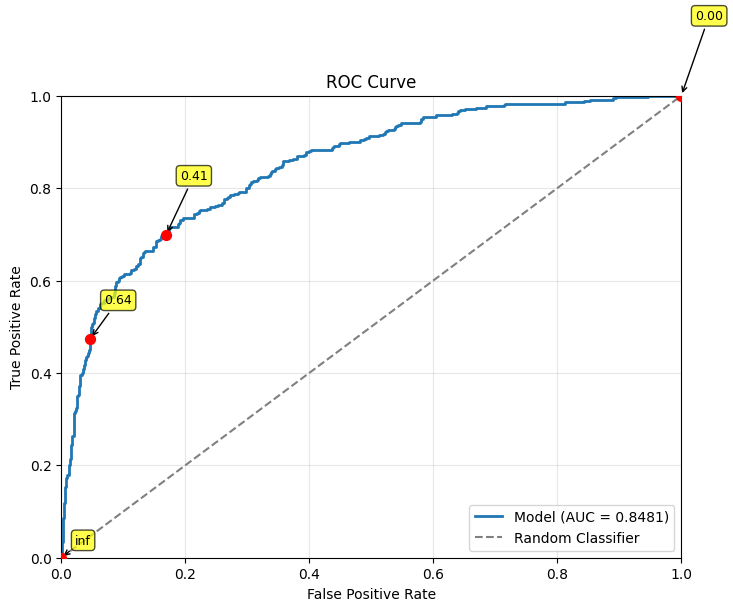

AUC-ROC: 0.8481


In [12]:
test_proba = best_model.predict_proba(best_model_data_splits.features_test)[:, 1] # type: ignore
auc_score = best_model_data_splits.auc_roc_curve(
    test_proba=test_proba
)

print(f'AUC-ROC: {auc_score:{dfem.F1_FORMAT}}')

## 5&emsp;Final Conclusion.

The high AUC-ROC score of 0.8481 validates the fundamental quality of the model.  
The F1 Score of 0.5983 validates the operational success and compliance of the model.